[(array([14964652.07664249,  7118982.76613167]), 0), (array([23474167.54564549, 11155670.2590547 ]), 0), (array([7627409.77578549, 3635240.67634144]), 1), (array([108156.17229419,  53038.64469567]), 0), (array([50274.60641285, 24922.126888  ]), 1), (array([4077138.50332809, 1947325.48559238]), 2), (array([403974.10363128, 195485.54962108]), 0), (array([8241850.82483886, 3927162.73860911]), 0), (array([9380379.07462757, 4467968.73400548]), 3), (array([14800.65469471,  7515.69790756]), 0)]


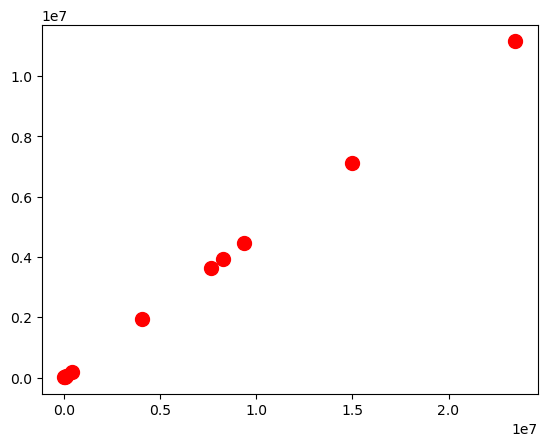

In [46]:
import numpy as np
import scipy.interpolate as interp
import matplotlib.pyplot as plt

def generate_path_colav_environment(No, Nw, Lp, mu_r, sigma_d):
    # Draw theta_start from Uniform(0, 2*pi)
    theta_start = np.random.uniform(0, 2 * np.pi)

    # Path origin and goal position
    p_start = 0.5 * Lp * np.array([np.cos(theta_start), np.sin(theta_start)])
    p_end = -p_start

    # Generate Nw random waypoints between p_start and p_end
    waypoints = np.linspace(p_start, p_end, Nw) + np.random.normal(0, Lp/10, (Nw, 2))
    waypoints[0] = p_start
    waypoints[-1] = p_end

    # Create smooth arc length parameterized path using PCHIP
    p = interp.PchipInterpolator(np.linspace(0, 1, Nw), waypoints, axis=0)

    obstacles = []

    # Generate No obstacles
    for _ in range(No):
        # Draw arclength omega_obst from Uniform(0.1 * Lp, 0.9 * Lp)
        omega_obst = np.random.uniform(0.1 * Lp, 0.9 * Lp)

        # Draw obstacle displacement distance d_obst from N(0, sigma_d^2)
        d_obst = np.random.normal(0, sigma_d**2)

        # Path angle gamma_obst
        gamma_obst = np.arctan2(p.derivative()(omega_obst)[1], p.derivative()(omega_obst)[0])

        # Obstacle position
        p_obst = p(omega_obst) + d_obst * np.array([np.cos(gamma_obst - np.pi/2), np.sin(gamma_obst - np.pi/2)])

        # Draw obstacle radius r_obst from Poisson(mu_r)
        r_obst = np.random.poisson(mu_r)

        # Add obstacle (p_obst, r_obst) to environment
        obstacles.append((p_obst, r_obst))

    return p, obstacles, waypoints

# Example usage
No = 10
Nw = 20
Lp = 20
mu_r = 1
sigma_d = 0.5

path, obstacles, waypoints = generate_path_colav_environment(No, Nw, Lp, mu_r, sigma_d)

# plt.scatter(waypoints[0,0], waypoints[0,1], s=100, c='b', label="Start")
# plt.scatter(waypoints[-1,0], waypoints[-1,1], s=100, c='r', label="End")
# plt.scatter(waypoints[:, 0], waypoints[:, 1], c='b', label="Waypoints")
# # Plot the trajectory
# t = np.linspace(0, 1, 1000)
# trajectory = path(t)
# plt.scatter(trajectory[:, 0], trajectory[:, 1], s=0.5, c='b', label="Trajectory")

# # Plot the waypoints
# waypoints = np.linspace(0, 1, Nw)
# waypoints_positions = path(waypoints)
# plt.plot(waypoints_positions[:, 0], waypoints_positions[:, 1], 'r', label="Waypoints")

# Plot the obstacles
print(obstacles)
for p_obst, r_obst in obstacles:
    plt.scatter(p_obst[0], p_obst[1], s=100, c='r', label="Obstacle")
    # circle = plt.Circle((p_obst[0], p_obst[1]), r_obst, color='r', alpha=0.5)
    # plt.gca().add_patch(circle)

# plt.legend()
# plt.xlabel("x")
# plt.ylabel("y")
# plt.title("Trajectory and Obstacles")
# plt.axis("equal")
# plt.grid()
# plt.show()

In [52]:
lp = 15 # path length
omega_obst = np.random.uniform(0.1 * Lp, 0.9 * Lp) # arclength
d_obst = np.random.normal(0, sigma_d**2) # obstacle displacement distance
print(d_obst)

0.05403785421323915


[(array([-3.252,  1.151]), 0.1), (array([2.008, 0.888]), 0.5983533169431544), (array([2.226, 1.286]), 0.49137376392627385), (array([-3.109,  0.529]), 0.6501247945150843), (array([2.102, 0.076]), 0.4983545079839654), (array([ 2.315, -1.181]), 0.6663286520134261), (array([1.55 , 0.151]), 0.1), (array([ 0.163, -1.663]), 0.24511926316221494), (array([3.613, 0.434]), 0.1), (array([ 0.46 , -1.727]), 0.1787328720588766), (array([-0.844, -1.193]), 0.7609873798279922), (array([2.777, 1.725]), 0.12662902696630657)]


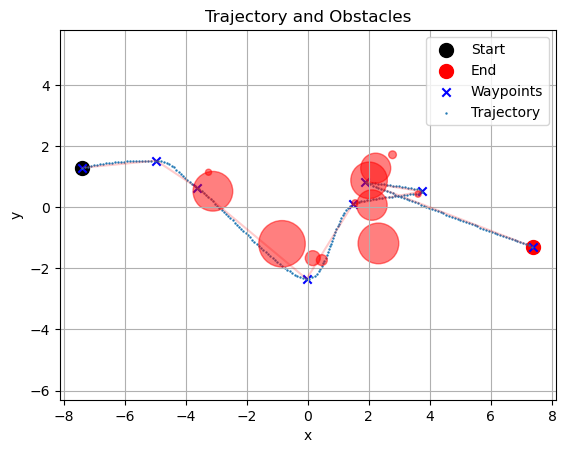

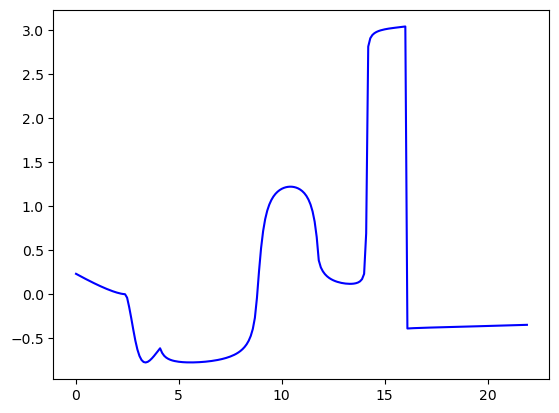

In [265]:
import numpy as np
import scipy.interpolate as interp
import matplotlib.pyplot as plt

np.seterr(all='ignore')
np.set_printoptions(precision=3, suppress=True)

def generate_path_colav_environment(No, Nw, Lp, mu_r, sigma_d):
    # Draw theta_start from Uniform(0, 2*pi)
    theta_start = np.random.uniform(0, 2 * np.pi)

    # Path origin and goal position
    p_start = 0.5 * Lp * np.array([np.cos(theta_start), np.sin(theta_start)])
    p_end = -p_start

    # Generate Nw random waypoints between p_start and p_end
    waypoints = np.linspace(p_start, p_end, Nw) + np.random.normal(0, Lp/10, (Nw, 2))
    waypoints[0] = p_start
    waypoints[-1] = p_end

    # Create smooth arc length parameterized path using PCHIP
    p = interp.PchipInterpolator(np.linspace(0, 1, Nw), waypoints, axis=0)

    obstacles = []

    # Generate No obstacles
    for _ in range(No):
        # Draw arclength omega_obst from Uniform(0.1 * Lp, 0.9 * Lp)
        omega_obst = np.random.uniform(0.1 * Lp, 0.9 * Lp)

        # Map omega_obst to normalized arclength
        norm_omega_obst = omega_obst / Lp

        # Draw obstacle displacement distance d_obst from N(0, sigma_d^2)
        d_obst = np.random.normal(0, sigma_d**2)

        # Path angle gamma_obst
        gamma_obst = np.arctan2(p.derivative()(norm_omega_obst)[1], p.derivative()(norm_omega_obst)[0])

        # Obstacle position
        p_obst = p(norm_omega_obst) + d_obst * np.array([np.cos(gamma_obst - np.pi/2), np.sin(gamma_obst - np.pi/2)])

        # Draw obstacle radius r_obst from Poisson(mu_r)
        r_obst = np.clip(np.random.normal(mu_r, 0.3), 0.1, 1)
        
        # Add obstacle (p_obst, r_obst) to environment
        obstacles.append((p_obst, r_obst))

    return waypoints, p, obstacles

def arc_length(path, t, dt):
    derivative = path.derivative()(t)
    return np.sqrt(np.sum(derivative**2, axis=1)) * dt


# Example usage
No = 12
Nw = 8
Lp = 15
mu_r = 0.25
sigma_d = 0.8

waypoints, path, obstacles = generate_path_colav_environment(No, Nw, Lp, mu_r, sigma_d)

# Calculate even trajectory points
t = np.linspace(0, 1, 1000)
dt = t[1] - t[0]
cumulative_arclength = np.cumsum(arc_length(path, t, dt))
point_distance = 0.1
total_arclength = cumulative_arclength[-1]
num_points = int(np.ceil(total_arclength / point_distance))
even_t = np.zeros(num_points)
current_arclength = 0
for i in range(1, num_points):
    current_arclength += point_distance
    even_t[i] = np.interp(current_arclength, cumulative_arclength, t)
even_trajectory = path(even_t)

# Calculate yaw angles at each point
path_derivative = path.derivative()(even_t)
yaw_angles = np.arctan2(path_derivative[:, 1], path_derivative[:, 0])

# plot waypoints
plt.scatter(waypoints[0,0], waypoints[0,1], s=100, c='k',  label="Start")
plt.scatter(waypoints[-1,0], waypoints[-1,1], s=100, c='r', label="End")
plt.scatter(waypoints[:, 0], waypoints[:, 1], c='b', marker='x',label="Waypoints")
plt.plot(waypoints[:, 0], waypoints[:, 1], 'r', alpha=0.2)

# Plot the trajectory
plt.scatter(even_trajectory[:, 0], even_trajectory[:, 1], s=2, marker='.', label="Trajectory")

# Plot the arrows of yaw angles
# for i, angle in enumerate(yaw_angles):
#     x, y = even_trajectory[i]
#     dx, dy = np.cos(angle), np.sin(angle)
#     plt.arrow(x, y, dx, dy, width=0.001, fc='r', ec='r')
    
# Plot the obstacles
print(obstacles)
for p_obst, r_obst in obstacles:
    circle = plt.Circle((p_obst[0], p_obst[1]), r_obst, color='r', alpha=0.5)
    plt.gca().add_patch(circle)
    # plt.scatter(p_obst[0], p_obst[1], s=100, c='r', label="Obstacle")

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Trajectory and Obstacles")
plt.axis("equal")
plt.grid()

even_arclength = np.interp(even_t, t, cumulative_arclength)

fig, ax = plt.subplots()
plt.plot(even_arclength, yaw_angles, 'b-', label="Yaw angle")

plt.show()


In [207]:
print(arclength.shape)
print(waypoints.shape)
print(trajectory.shape)
print(yaw_angles.shape)


(100,)
(8, 2)
(100, 2)
(100,)


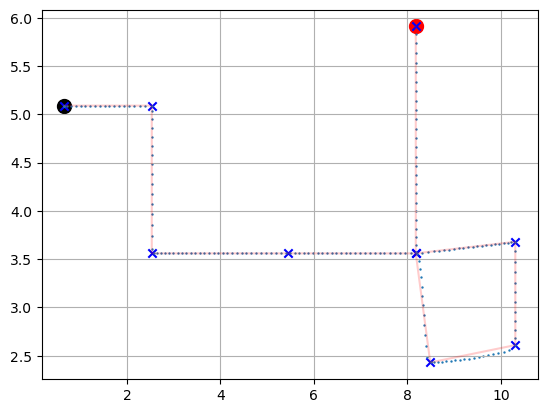

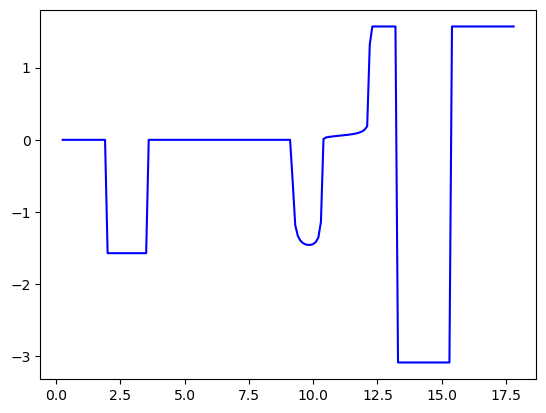

In [260]:
x = [0.66, 2.53, 2.53, 5.44, 8.18, 8.49, 10.31, 10.31, 8.18, 8.18]
y = [5.09, 5.09, 3.56, 3.56, 3.56, 2.43, 2.61, 3.68, 3.56, 5.91]
Nw = len(x)
waypoints = np.column_stack((x, y))
path = interp.PchipInterpolator(np.linspace(0, 1, Nw), waypoints, axis=0)
# Calculate even trajectory points
t = np.linspace(0, 1, 100)
dt = t[1] - t[0]
cumulative_arclength = np.cumsum(arc_length(path, t, dt))
point_distance = 0.1
total_arclength = cumulative_arclength[-1]
num_points = int(np.ceil(total_arclength / point_distance))
even_t = np.zeros(num_points)
current_arclength = 0
for i in range(1, num_points):
    current_arclength += point_distance
    even_t[i] = np.interp(current_arclength, cumulative_arclength, t)
even_trajectory = path(even_t)

# calculate yaw angles at each point
even_arclength = np.interp(even_t, t, cumulative_arclength)
# Calculate yaw angles at each point
path_derivative = path.derivative()(even_t)
yaw_angles = np.arctan2(path_derivative[:, 1], path_derivative[:, 0])

# plot waypoints
plt.scatter(waypoints[0,0], waypoints[0,1], s=100, c='k',  label="Start")
plt.scatter(waypoints[-1,0], waypoints[-1,1], s=100, c='r', label="End")
plt.scatter(waypoints[:, 0], waypoints[:, 1], c='b', marker='x',label="Waypoints")
plt.plot(waypoints[:, 0], waypoints[:, 1], 'r', alpha=0.2)
# Plot the trajectory
plt.scatter(even_trajectory[:, 0], even_trajectory[:, 1], s=2, marker='.', label="Trajectory")
plt.grid()

fig, ax = plt.subplots()
plt.plot(even_arclength, yaw_angles, 'b-', label="Yaw angle")